## <center>Курсовой проект для курса "Библиотеки Python для Data Science"
### Задание:
Используя данные из обучающего датасета (train.csv), построить модель для предсказания цен на недвижимость (квартиры). С помощью полученной модели, предсказать цены для квартир из тестового датасета (test.csv).
### Целевая переменная:
Price
### Метрика качества:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)    
$$ \ R^2 = 1 - \frac{\sigma^2}{\sigma_y^2} $$
### Описание датасета:
Id - идентификационный номер квартиры
    
DistrictId - идентификационный номер района
    
Rooms - количество комнат
    
Square - площадь
    
LifeSquare - жилая площадь
    
KitchenSquare - площадь кухни
    
Floor - этаж
    
HouseFloor - количество этажей в доме
    
HouseYear - год постройки дома
    
Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
    
Social_1, Social_2, Social_3 - социальные показатели местности
    
Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
    
Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
    
Price - цена квартиры

Подгружаем необходимые библиотеки:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.ensemble import GradientBoostingRegressor

%matplotlib inline

### 1. Загружаем данные:

In [2]:
DATA_TRAIN_PATH='/kaggle/input/realestatepriceprediction/train.csv'
DATA_TEST_PATH='/kaggle/input/realestatepriceprediction/test.csv'
RESULT_PATH='./predictions.csv'
data=pd.read_csv(DATA_TRAIN_PATH)
X_test=pd.read_csv(DATA_TEST_PATH)

### 2. Анализ датасета

In [3]:
df=data.copy()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

В тренировочном датасете 10000 строк и 19 столбцов.<br>
Видим, что признаки LifeSquare и Healthcare_1 имеют пропуски. Необходимо будет принять решение, каким образом их обрабатывать.<br>
Так же видим нечисловые признаки: Ecology_2, Ecology_3, Shops_2.<br>
Кроме того, DistrictId и Id нужно отнести к категориальным признакам.

In [5]:
df.DistrictId=df.DistrictId.astype('object')
df.Id=df.Id.astype('object')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  object 
 1   DistrictId     10000 non-null  object 
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

Взглянем на числовые признаки:

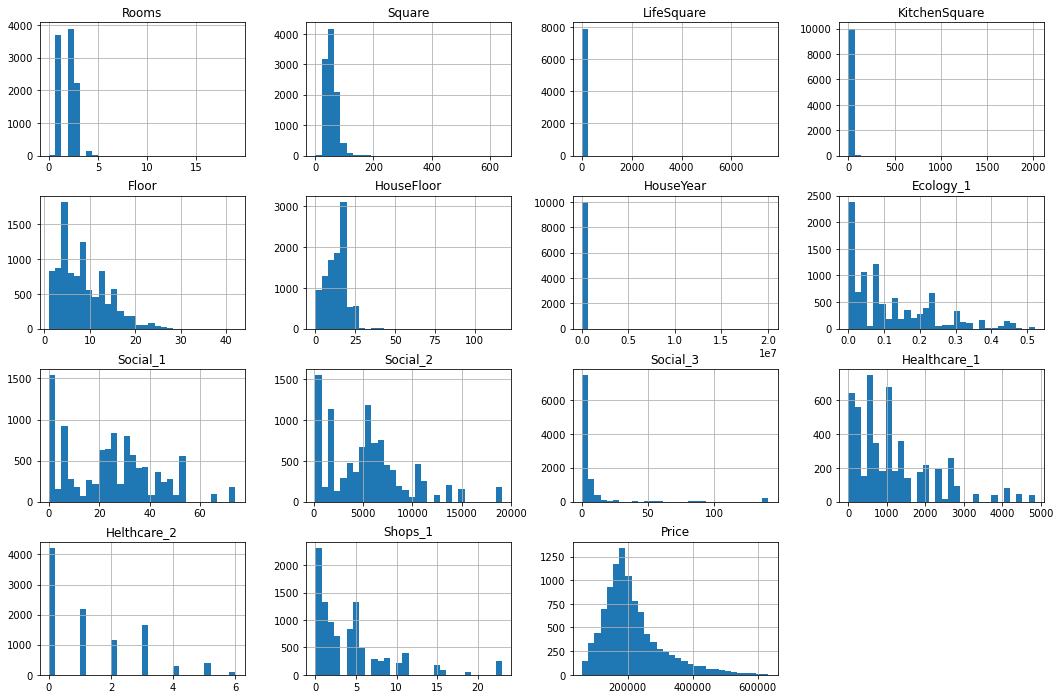

In [6]:
digital_features=df.select_dtypes(exclude=['object'])
digital_features.hist(figsize=(18,12), bins=30)
plt.show()

Явно заметно наличие выбросов в количестве комнат, площадях, годах постройки дома.<br>
Helthcare_2 - скорее относится к категориальным признакам.<br>
Показатели местности Social, и Shops интерпретировать трудно.

In [7]:
df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


Действительно, описание датасета подтверждает наши заключения по показателям признаков.

Посмотрим на выбросы:<br>
Исспользуем логарифмическую шкалу, для того, чтобы ящики не были слишком узкими.

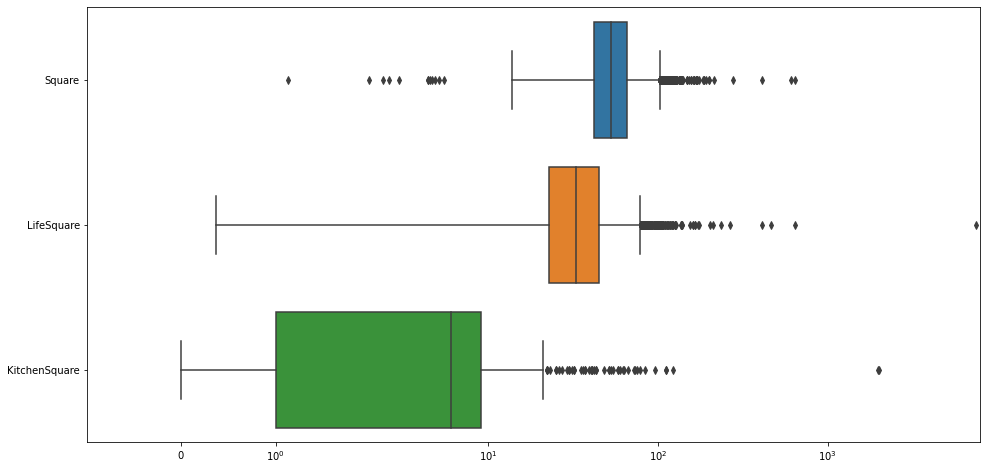

In [8]:
plt.figure(figsize=(16, 8))
sns.boxplot(data=df[['Square', 'LifeSquare', 'KitchenSquare']], orient='h')
plt.xscale('symlog')
plt.xlim(left=-1)
plt.show()

Для недвижимости одним из важных признаков является цена за квадратный метр. Введем данный признак в датасет.

In [9]:
df.insert(2,'SqMeterPrice', df.Price/df.Square)

In [10]:
df.describe()

,SqMeterPrice,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,3988.383777,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,3755.437224,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,208.293451,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,2918.525328,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,3910.052336,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,4692.375993,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,230463.537966,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


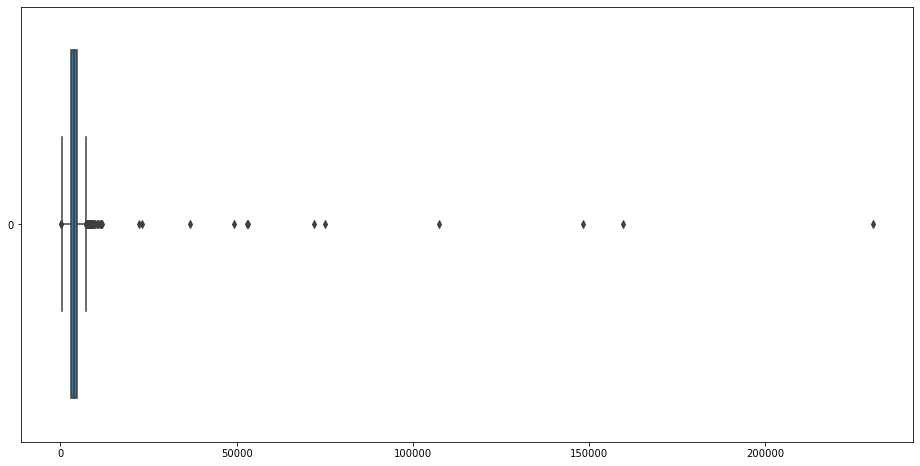

In [11]:
# Взглянем на выбросы:
plt.figure(figsize=(16, 8))
sns.boxplot(data=df.SqMeterPrice, orient='h')
plt.show()

Попробуем разобраться с площадью недвижимости

In [12]:
df.sort_values(by='Square', axis=0, ascending=True).head()

,Id,DistrictId,SqMeterPrice,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,...,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
6392,14786,1,159593.107918,1.0,1.136859,4.525736,1.0,3,1.0,1977,...,B,B,1,264,0,NaN,0,1,B,181434.825589
8283,15744,34,230463.537966,1.0,1.988943,2.642219,1.0,21,4.0,1977,...,B,B,53,13670,4,NaN,1,11,B,458378.777006
4853,3224,27,53253.578837,0.0,2.377248,0.873147,0.0,1,0.0,1977,...,B,B,2,469,0,NaN,0,0,B,126596.941798
1608,10202,6,52996.529388,1.0,2.596351,4.604943,1.0,3,25.0,2014,...,B,B,5,1564,0,540.0,0,0,B,137597.601458
9294,6782,45,148259.792432,1.0,2.954309,5.257278,1.0,3,1.0,1977,...,B,B,23,5212,6,NaN,3,2,B,438005.182323


Датасет явно заполнен мусорными данными, трудно представить себе жилые помещения площадью 6 кв. м.<br>Цена за кв.м тоже намекает об этом.<br>То же можно сказать о помещениях с площадью более 400 кв. м. и с низкой ценой за метр.

In [13]:
df.loc[(df.Square<1.3), 'Square']= df['Square']*100
df.loc[(df.Square<=13), 'Square']= df['Square']*10
df.loc[(df.Square>300), 'Square']= df['Square']/10

In [14]:
df.drop('SqMeterPrice', axis=1, inplace=True)
df.insert(2,'SqMeterPrice', df.Price/df.Square)

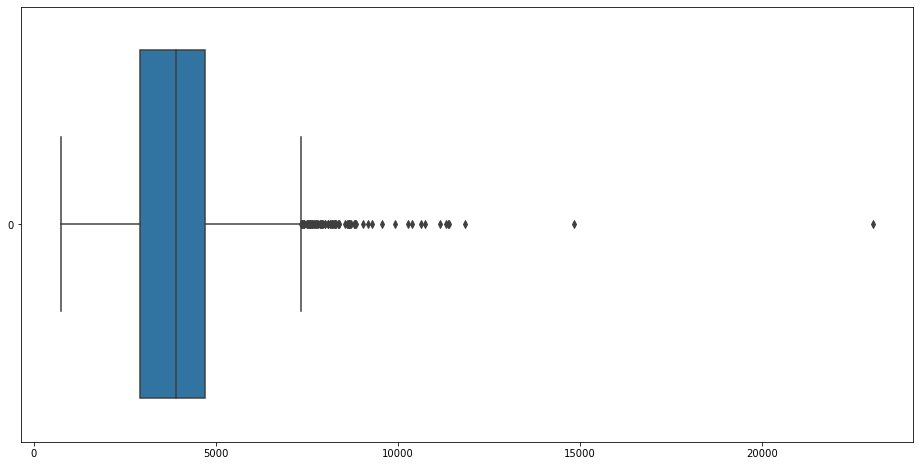

In [15]:
plt.figure(figsize=(16, 8))
sns.boxplot(data=df.SqMeterPrice, orient='h')
plt.show()

Избавились от совсем низких значений стоимости квадратного метра. Высокую стоимость трогать не будем, т.к. это могут быть элитные объекты недвижимости

Взглянем на корреляцию признков в датасете:

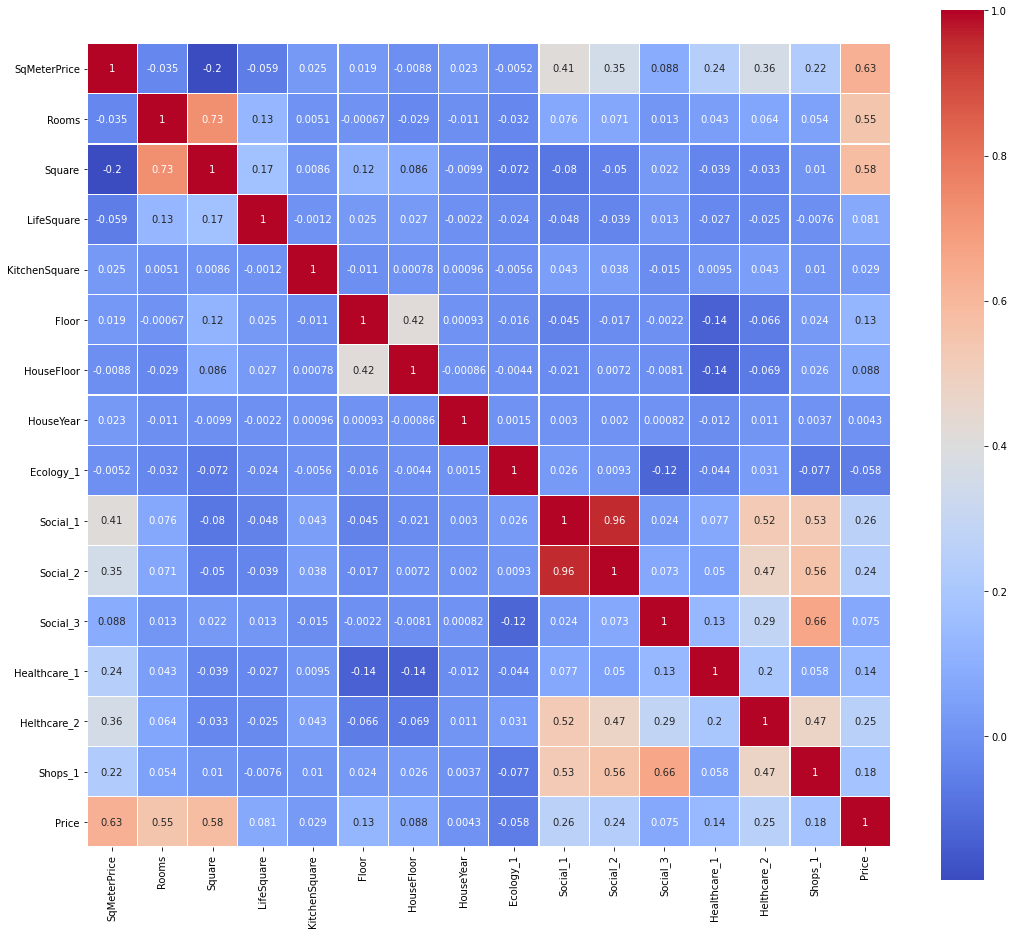

In [16]:
df_corr=df.corr()
plt.figure(figsize=(18,16))
sns.heatmap(df_corr, annot=True, linewidths=0.3, cmap='coolwarm', square=True)
plt.show()

Видим, что целевая переменная сильно зависит от количества комнат и площади

In [17]:
df.Rooms.unique()

array([ 2.,  3.,  1.,  4., 10.,  0.,  5., 19.,  6.])

In [18]:
df[df.Rooms>6]

,Id,DistrictId,SqMeterPrice,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,...,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
377,5927,57,5372.190561,10.0,59.056975,36.223072,10.0,22,22.0,2002,...,B,B,74,19083,2,NaN,5,15,B,317265.323792
1454,8491,1,1865.555669,19.0,42.006046,21.779288,7.0,17,17.0,2014,...,B,B,1,264,0,NaN,0,1,B,78364.616704
8849,14865,9,2831.044647,10.0,60.871266,38.420681,10.0,3,2.0,1994,...,B,B,25,5648,1,30.0,2,4,B,172329.270863


In [19]:
df[df.Rooms==0]

,Id,DistrictId,SqMeterPrice,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,...,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
1397,12638,27,1938.880408,0.0,138.427694,136.215499,0.0,4,3.0,2016,...,B,B,11,3097,0,NaN,0,0,B,268394.744389
1981,7917,27,1419.282909,0.0,212.932361,211.231125,0.0,2,3.0,2008,...,B,B,9,1892,0,NaN,0,1,B,302211.260887
2269,7317,27,2348.119347,0.0,41.790881,NaN,0.0,13,0.0,1977,...,B,B,9,1892,0,NaN,0,1,B,98129.976788
3911,770,28,4385.488771,0.0,49.483501,NaN,0.0,16,0.0,2015,...,B,B,30,6207,1,1183.0,1,0,B,217009.338463
4366,456,6,2612.112170,0.0,81.491446,NaN,0.0,4,0.0,1977,...,B,B,5,1564,0,540.0,0,0,B,212864.799112
4853,3224,27,5325.357884,0.0,23.772476,0.873147,0.0,1,0.0,1977,...,B,B,2,469,0,NaN,0,0,B,126596.941798
6149,3159,88,4108.784399,0.0,38.697117,19.345131,9.0,9,16.0,1982,...,B,B,43,8429,3,NaN,3,9,B,158998.110646
8834,9443,27,2498.580012,0.0,87.762616,85.125471,0.0,5,15.0,1977,...,B,B,9,1892,0,NaN,0,1,B,219281.918007


In [20]:
df.Rooms.mode()

0    2.0
dtype: float64

Надо будет заменить значения выше 6 и меньше 1 на наиболеее частые значения количества комнат.<br>
Исходя из соображений о рынке недвижимости, цена за кв.м. может зависить от расположения квартиры и количества комнат, поэтому, при подготовке данных для обучения учтем и этот вариант, для формирования средей стоимости за квадратный метр.

Посмотрим на пропуски в данных:

In [21]:
df.isnull().sum()

Id                  0
DistrictId          0
SqMeterPrice        0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

2113 пропусков в LifeSquare, 4798 в Healthcare_1. Есть большой соблазн избавиться от Healthcare_1.
Но сначала попробуем разобраться с непонятными признаками, связанными с экологией, здоровьем, магазинами и т.д.

In [22]:
for feature in df.columns[10:-1]:
    print(f'Признак - {feature}\tУникальных значений - {df[feature].nunique()}.')

Признак - Ecology_1	Уникальных значений - 129.
Признак - Ecology_2	Уникальных значений - 2.
Признак - Ecology_3	Уникальных значений - 2.
Признак - Social_1	Уникальных значений - 51.
Признак - Social_2	Уникальных значений - 142.
Признак - Social_3	Уникальных значений - 30.
Признак - Healthcare_1	Уникальных значений - 79.
Признак - Helthcare_2	Уникальных значений - 7.
Признак - Shops_1	Уникальных значений - 16.
Признак - Shops_2	Уникальных значений - 2.


Уникальных значений немного, и скорее всего они являются характеристиками района, или его части. Следовательно, пропуски в Healthcare_1 можно попробовать заполнить методом 'pad'('ffill'), отсортировав датасет по району.<br>Пропуски по жилой площади заполним аналогично, предварительно отсортировав датасет по общей площади.

Так же можно трансформировать год постройки дома в более понятный возраст дома.

К категориальным признакам применим метод кодирования One-Hot-Encoding

Поскольку предполагается использовать в качестве модели градиентный бустинг, не будем трогать остальные признаки, надеемся, что наша модель справится.

### 3. Подготовка данных:

Создадим класс FeaturesGenerator, в котором реализуем наши идеи относительно подготовки данных для модели.

In [23]:
class FeaturesGenerator():
    
    def __init__(self):
        
        self.current_year=None
        self.cat_columns=None
        self.rsqm=None
        self.nsqm=None
        
        
    def fit(self,df):
        
        # Текущий год, для вычисления возраста дома
        
        self.current_year=datetime.datetime.now().year
        
        # Корректируем значения площадей, и количество комнат
        
        df.loc[(df.Square<1.3), 'Square']= df['Square']*100
        df.loc[(df.Square<=13), 'Square']= df['Square']*10
        df.loc[(df.Square>300), 'Square']= df['Square']/10
        df.loc[((df.Rooms>6)|(df.Rooms==0)), 'Rooms']=2
       
        
        # Добавляем стоимость кв.м для последующей агрегации данных в обучающей и тестовой выборках
        
        df.insert(1, 'SqMeterPrice',df['Price']/df['Square'])
        
        # Вычисляем на тесте среднюю стоимость кв.м в зависимости от к-ва комнат(для обработки пропусков в тестовом датасете),
        # и среднюю стоимость кв.м в зависимости от района и количества комнат
        
        self.rsqm=df.groupby(by=['Rooms'])['SqMeterPrice'].mean().rename('RoomSqMeterPrice', inplace=True)
        self.nsqm=df.groupby(by=['DistrictId','Rooms'])['SqMeterPrice'].mean().rename('DistSqMeterPrice', inplace=True) 
        
        # Удаляем лишнее
        
        df.drop('SqMeterPrice', axis=1, inplace=True)
        
        # Назначаем столбцы для последующего дамми-кодирования
        
        self.cat_columns=df.select_dtypes('object').columns
        
        
        
    def transform(self, df):
        
        # Заменяем год постройки дома на возраст дома(выбросы по году постройки предварительно исправляем на текущий год)
        
        df.loc[(df.HouseYear>self.current_year),'HouseYear']=self.current_year-1
        df.insert(df.columns.get_loc('HouseYear'), 'HousAge', self.current_year - df['HouseYear'])
        df.drop('HouseYear', axis=1, inplace=True)
       
        # Кодируем категориальные переменные
        
        df=pd.get_dummies(df, columns=self.cat_columns)
        
        # Корректируем значения площадей в тестовом датасете
        
        df.loc[(df.Square<1.3), 'Square']= df['Square']*100
        df.loc[(df.Square<=13), 'Square']= df['Square']*10
        df.loc[(df.Square>300), 'Square']= df['Square']/10
        
        # Корректируем количество комнат в тестовом датасете
        
        df.loc[((df.Rooms>6)|(df.Rooms==0)), 'Rooms']=2
                
        # Обрабатываем пропуски полях Healthcare_1 и LifeSquare, заполняя их методом 'pad'
        
        df=df.sort_values(by='DistrictId')
        df.Healthcare_1.fillna(method='pad',inplace=True)
        df=df.sort_values(by='Square')
        df.LifeSquare.fillna(method='pad',inplace=True)
        df.sort_index(inplace=True)
        
        # Добавляем поле DistSqMeterPrice содержащее среднюю стоимость кв.м в зависимости от района и количества комнат
        
        df=df.merge(self.rsqm, how='left', on='Rooms')
        df=df.merge(self.nsqm, how='left', on=['DistrictId', 'Rooms'])
        df.insert(1, 'DistSqMeterPrice', df.pop('DistSqMeterPrice'))
        
        # Заменяем пропуски, которые получились из-за того, что в тесте и трейне есть несовпадающие по Id районы,
        # на среднюю стоимость кв.м в зависимости от площади
        
        df.DistSqMeterPrice.fillna(df.RoomSqMeterPrice, inplace=True)
        
        # Удаляем лишнее
        
        df.drop('RoomSqMeterPrice', axis=1, inplace=True)
        
        # Переводим DistrictId, и Id в нечисловые признаки
        
        df['DistrictId']=df['DistrictId'].astype('object')
        df['Id']=df['Id'].astype('object')
        
        return df

Преобразуем данные:

In [24]:
generator=FeaturesGenerator()
generator.fit(data)
DF=generator.transform(data)
X_test=generator.transform(X_test)

In [25]:
DF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Id                10000 non-null  object 
 1   DistSqMeterPrice  10000 non-null  float64
 2   DistrictId        10000 non-null  object 
 3   Rooms             10000 non-null  float64
 4   Square            10000 non-null  float64
 5   LifeSquare        10000 non-null  float64
 6   KitchenSquare     10000 non-null  float64
 7   Floor             10000 non-null  int64  
 8   HouseFloor        10000 non-null  float64
 9   HousAge           10000 non-null  int64  
 10  Ecology_1         10000 non-null  float64
 11  Social_1          10000 non-null  int64  
 12  Social_2          10000 non-null  int64  
 13  Social_3          10000 non-null  int64  
 14  Healthcare_1      10000 non-null  float64
 15  Helthcare_2       10000 non-null  int64  
 16  Shops_1           10000 non-null  int64  

In [26]:
DF.shape, X_test.shape

((10000, 24), (5000, 23))

### 4. Выбор и обучение модели

В качестве модели предсказания мной выбрана модель GradientBoostingRegressor из библиотеки sklearn. Такие модели хорошо справляются с немасштабированым данными, устойчивы к переобучению, находят сложные зависимости в признаках. Однако подбор параметров представляет некоторую сложность.<br>Параметры модели были подобраны при помощи GridSearchCV.

Отделяем от датафрейма целевую переменную Price, так же удалим столбец Id который не несет смысловой нагрузки для модели.

In [27]:
y_train=DF.Price
X_train=DF.drop(['Id', 'Price'], axis=1)
# Столбец 'Id' из тестовых данных сохраним, он будет нужен для файла с результатом
test_idx=X_test.pop('Id')

In [28]:
X_train.shape, X_test.shape, y_train.shape

((10000, 22), (5000, 22), (10000,))

In [29]:
%%time
from sklearn.ensemble import GradientBoostingRegressor
model=GradientBoostingRegressor(learning_rate=0.02, max_depth=5, max_features=0.5, n_estimators=700, random_state=24 )
model.fit(X_train, y_train)
pred=model.predict(X_test)


CPU times: user 14.1 s, sys: 9.96 ms, total: 14.1 s
Wall time: 14.1 s


Скор модели на обучающей выборке:

In [30]:
model.score(X_train,y_train)

0.877005513469941

Посмотрим на предсказания:

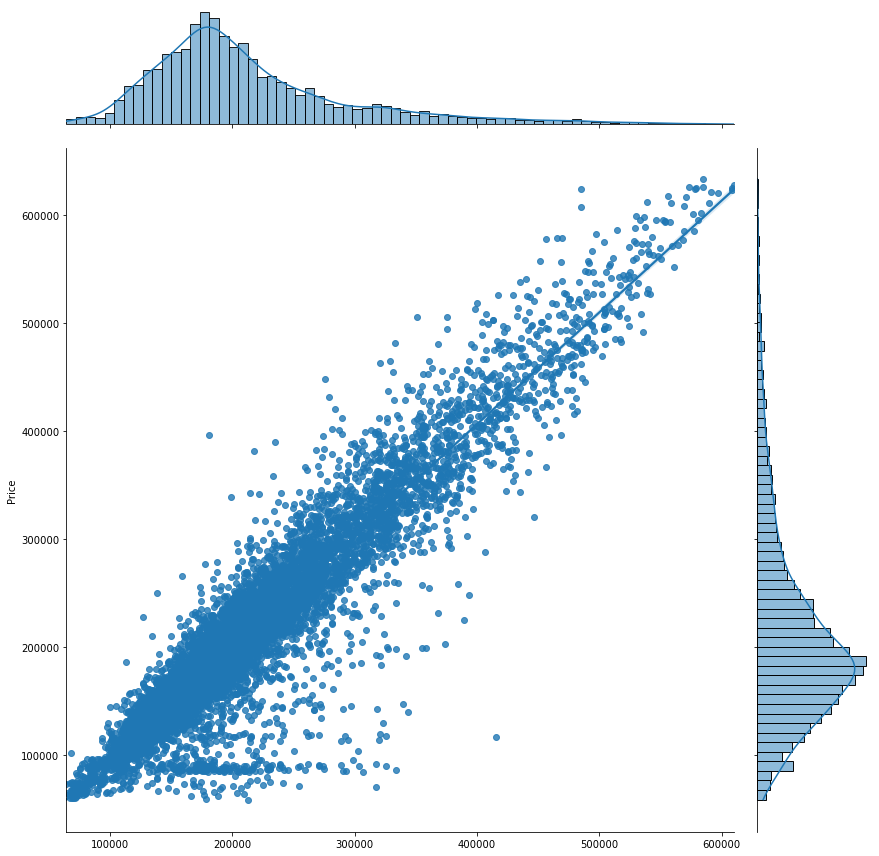

In [31]:
sns.jointplot(x=model.predict(X_train), y=y_train, kind='reg', height=12)
plt.show()

Видим неприятный хвост в районе 70000-90000, модель завышает стоимость квартир со стоимостью от 70000 до 90000.

Посмотрим, какие признаки модель сочла значимыми:

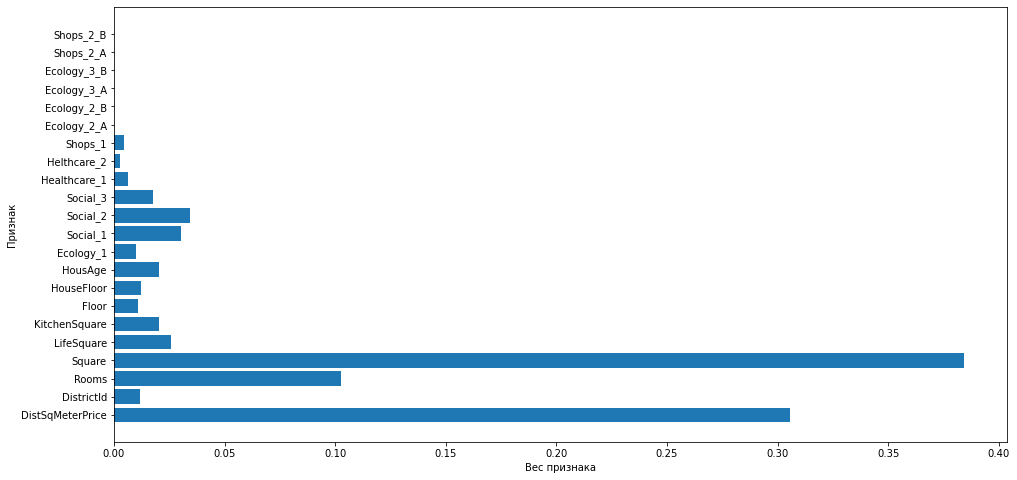

In [32]:
plt.figure(figsize=(16,8))
plt.barh(X_train.columns.tolist(), model.feature_importances_)
plt.xlabel('Вес признака')
plt.ylabel('Признак')
plt.show()

### 5. Загрузка результата

In [33]:
result=pd.DataFrame({'Id':test_idx, 'Price':pred})
result.head()

,Id,Price
0,725,154045.087385
1,15856,208734.181862
2,5480,65477.229682
3,15664,308447.303429
4,14275,140005.061992


In [34]:
result.to_csv(RESULT_PATH, index=False)